In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score
import os
import tensorflow as tf
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pathlib
import tensorflow_datasets as tfds
from sklearn.metrics import f1_score
import sklearn
import seaborn as sns
import pandas as pd

In [2]:
# Change the path to the folder containing the folders train and set
%store -r dst_dir
datasets_path = dst_dir 
train_data_path = os.path.join(datasets_path, 'train')
test_data_path = os.path.join(datasets_path, 'test')

In [3]:
# Split the dataset in training/validation/test
train_data, val_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_path, 
    color_mode='grayscale',
    labels = 'inferred',
    image_size=(84, 84),
    shuffle=True,
    validation_split=0.25,
    seed=22,
    subset='both'

)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_path,
    color_mode='grayscale',
    labels = 'inferred',
    image_size=(84, 84),
    shuffle=False,
    validation_split=None,
    seed=22,
    subset=None)

Found 8000 files belonging to 50 classes.
Using 6000 files for training.
Using 2000 files for validation.
Found 2000 files belonging to 50 classes.


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint

In [5]:
img_height = 84
img_width = 84

rescale_layer = Rescaling(1./255, input_shape=(img_height, img_width, 1))

@tf.function
def rescale_fn(x, y):
    return rescale_layer(x), y

train_data_rescaled = train_data.map(rescale_fn)
val_data_rescaled = val_data.map(rescale_fn)
test_data_rescaled = test_data.map(rescale_fn)

In [6]:
filters = 32
num_classes = 50
dropout_coeff = 0.2

model = Sequential()

# First convolution layer
model.add(Conv2D(filters, (3,3), input_shape=(img_height, img_width, 1)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(dropout_coeff, input_shape=(39, 39)))

# Second convolution layer
model.add(Conv2D(filters, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(dropout_coeff, input_shape=(17, 17)))

# Third convolution layer
model.add(Conv2D(filters, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(dropout_coeff, input_shape=(8, 8)))

# Fully Connected Layer #1
model.add(Flatten())
model.add(Dense(64))
model.add(Activation("tanh")) #relu

# Fully Connected Layer #2
model.add(Dense(64))
model.add(Activation("tanh")) #relu

# Last Fully Connected Layer, 50 Outputs
model.add(Dense(num_classes))
model.add(Activation("softmax"))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 82, 82, 32)        320       
                                                                 
 activation (Activation)     (None, 82, 82, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 41, 41, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 41, 41, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 39, 39, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 39, 39, 32)        0         
                                                        

In [8]:
tf.keras.optimizers.Adam(learning_rate=0.01)

# Compile the Model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [9]:
epochs = 30

# ModelCheckpoint callback to save the best parameters
checkpoint = ModelCheckpoint(filepath='weights.best.hdf5', 
                             save_best_only=True, 
                             monitor='val_loss', 
                             mode='min', 
                             save_weights_only=False)

# Train the model
history = model.fit(train_data_rescaled, 
                    validation_data=val_data_rescaled, 
                    epochs=epochs,
                    callbacks=[checkpoint])

Epoch 1/30
188/188 [==============================] - 24s 118ms/step - loss: 2.0535 - accuracy: 0.5870 - val_loss: 0.9695 - val_accuracy: 0.8550
Epoch 2/30
188/188 [==============================] - 19s 101ms/step - loss: 0.6723 - accuracy: 0.8993 - val_loss: 0.3953 - val_accuracy: 0.9405
Epoch 3/30
188/188 [==============================] - 21s 110ms/step - loss: 0.3190 - accuracy: 0.9550 - val_loss: 0.2219 - val_accuracy: 0.9635
Epoch 4/30
188/188 [==============================] - 21s 109ms/step - loss: 0.1678 - accuracy: 0.9802 - val_loss: 0.1480 - val_accuracy: 0.9725
Epoch 5/30
188/188 [==============================] - 22s 116ms/step - loss: 0.1015 - accuracy: 0.9903 - val_loss: 0.1150 - val_accuracy: 0.9770
Epoch 6/30
188/188 [==============================] - 22s 116ms/step - loss: 0.0662 - accuracy: 0.9958 - val_loss: 0.0851 - val_accuracy: 0.9840
Epoch 7/30
188/188 [==============================] - 23s 121ms/step - loss: 0.0458 - accuracy: 0.9972 - val_loss: 0.0744 - val_ac

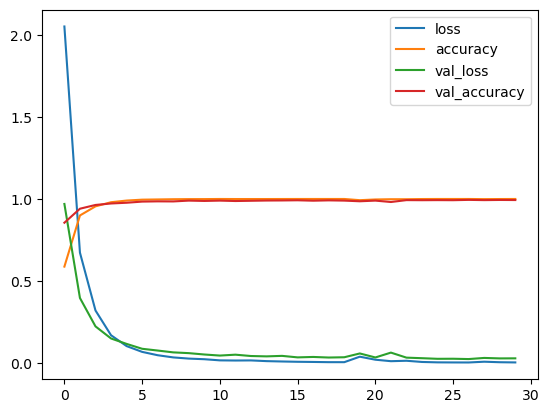

In [10]:
#Training and validation loss/accuracy trend
epoch_num = list(range(0, epochs))
plt.plot(epoch_num, history.history['loss'], label = 'loss')
plt.plot(epoch_num, history.history['accuracy'], label = 'accuracy')
plt.plot(epoch_num, history.history['val_loss'], label = 'val_loss')
plt.plot(epoch_num, history.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

In [11]:
model.load_weights('weights.best.hdf5')

# Predict on the test data
prediction = model.predict(test_data_rescaled)

63/63 [==============================] - 4s 59ms/step


In [12]:
# Evaluate on test data
evaluation = model.evaluate(
    test_data_rescaled,
    batch_size=32,
    verbose=0,
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False,
)

print('Loss: ', evaluation[0])
print('Accuracy: ', evaluation[1])

Loss:  0.023649457842111588
Accuracy:  0.9929999709129333


In [13]:
# True labels of the test set
y_true = np.concatenate([y for x, y in test_data_rescaled], axis=0)
# Predicted labels
y_pred = tf.argmax(prediction, axis=1).numpy()

# Get the true labels for the test data
test_labels = np.argmax(y_true)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')
f1 = f1_score(y_true, y_pred, average='micro')

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

Precision: 0.9930
Recall: 0.9930
F1 Score: 0.9930


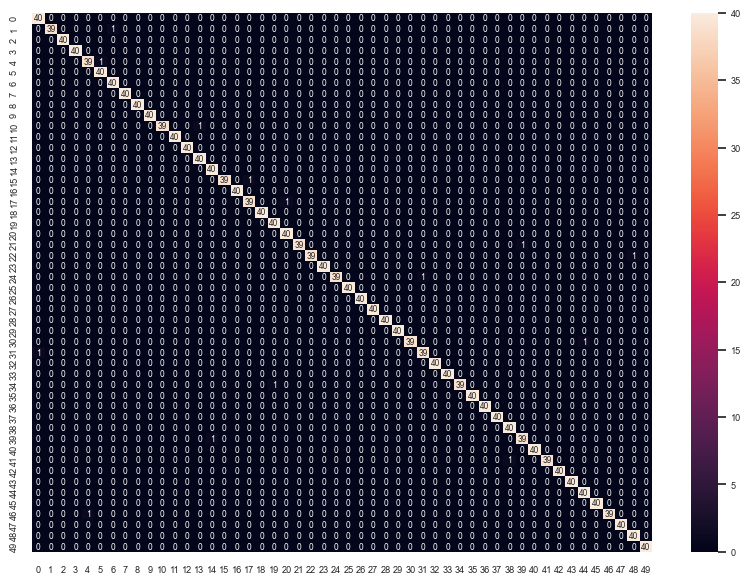

In [14]:
# Build the confusion matrix
conf_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()

# Plot the confusion matrix
df_cm = pd.DataFrame(conf_matrix, range(50), range(50)) 
plt.figure(figsize=(10,7))
sns.set(font_scale=0.6) 
sns.heatmap(df_cm, annot=True, annot_kws={"size": 6})

plt.show()

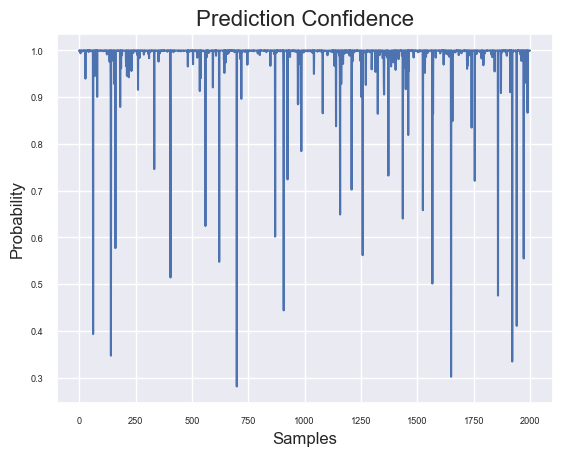

In [15]:
y_prob = [max(vector) for vector in prediction]

# Confidence for the predictions in the test set
plt.plot(range(2000) ,y_prob)
plt.title("Prediction Confidence", fontsize=16)
plt.xlabel("Samples", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.show()

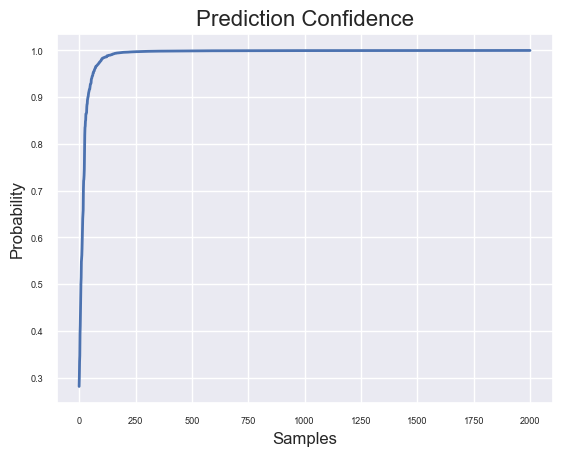

In [16]:
y_prob.sort()

# Confidence for the predictions in the test set in ascending order
plt.plot(range(2000), y_prob, linewidth=2) 
plt.title("Prediction Confidence", fontsize=16) 
plt.xlabel("Samples", fontsize=12) 
plt.ylabel("Probability", fontsize=12) 

plt.show()

In [17]:
target_prob = [0.6, 0.7, 0.8, 0.9]
for prob in target_prob:
    y_low = [val for val in y_prob if val < prob]
    print('Prediction with a probability of less than ',prob ,': ', len(y_low), 'on 2000 predictions')

Prediction with a probability of less than  0.6 :  14 on 2000 predictions
Prediction with a probability of less than  0.7 :  19 on 2000 predictions
Prediction with a probability of less than  0.8 :  25 on 2000 predictions
Prediction with a probability of less than  0.9 :  39 on 2000 predictions


In [18]:
wrong_predictions = []

for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
        wrong_predictions.append([i, y_true[i], y_pred[i]])

In [19]:
%store -r label_dict

def wrong_prediction(i):  # Prints the i-th wrong predicted image
    try:
        labels = os.listdir(test_data_path)
        image_folder = labels[wrong_predictions[i][0]//40]
        image_folder_path = os.path.join(test_data_path, image_folder)
        images = os.listdir(image_folder_path)
        wrong_image_path = os.path.join(image_folder_path, images[wrong_predictions[i][0]%40])
        wrong_image =  mpimg.imread(wrong_image_path)
        plt.imshow(wrong_image, cmap = plt.cm.binary)
        plt.grid(None)
        plt.show()
        print('True label:', label_dict[wrong_predictions[i][1]], '        Predicted label:', label_dict[wrong_predictions[i][2]])
    except:
        print(f"The directory does not contain {i} files")
    return

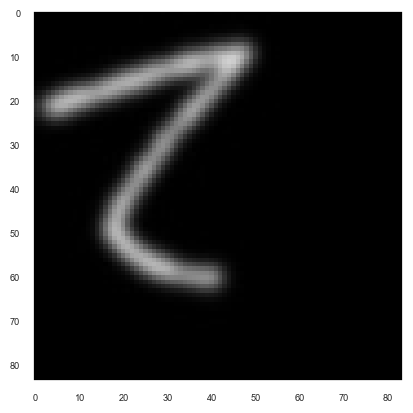

True label: TE         Predicted label: SO


In [20]:
# Print a wrongly predicted image
wrong_prediction(12)